# Multilayer Perceptron (MLP) 

This notebook demonstrates a **Multilayer Perceptron (MLP)** classifier
implemented entirely from scratch using the custom
`MultilayerPerceptron` class from the `rice_ml` package.

We build on the ideas introduced in the **single-layer perceptron** and show how adding hidden layers enables the model to learn **nonlinear
decision boundaries**.

This notebook will:

- Review the limitations of the perceptron
- Introduce hidden layers and nonlinear activations
- Train an MLP on a real dataset
- Compare performance against a single-layer perceptron

## Why Go Beyond the Perceptron?

The single-layer perceptron has a fundamental limitation:

It can only learn **linearly separable** decision boundaries.

This means it cannot solve problems such as:
- XOR
- Complex medical or signal datasets
- Nonlinear class boundaries

The Multilayer Perceptron (MLP) overcomes this limitation by introducing:
- Hidden layers
- Nonlinear activation functions


### Perceptron Decision Function

The single-layer perceptron computes predictions using a linear decision rule:

$$
\hat{y} = \text{sign}(Xw + b)
$$

where:
- X is the feature matrix
- w is the weight vector
- b is the bias term



### Multilayer Perceptron Forward Pass

A Multilayer Perceptron extends the perceptron by stacking layers.

An MLP consists of:
- An input layer
- One or more hidden layers
- An output layer

Hidden layers allow the model to learn **nonlinear decision boundaries**.

For an MLP with one hidden layer, the forward computation is:

$$
Z_1 = X W_1 + b_1
$$

$$
A_1 = \phi(Z_1)
$$

$$
Z_2 = A_1 W_2 + b_2
$$

$$
\hat{y} = \sigma(Z_2)
$$


Where:
- `φ` is a hidden-layer activation (e.g. ReLU)
- `σ` is the sigmoid function for binary classification
- Training is performed using **backpropagation**



### Activation Functions

Activation functions introduce nonlinearity.

Common choices include:
- ReLU: phi(z) = max(0, z)
- Sigmoid:
  
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Without nonlinear activations, stacked layers collapse into a single linear model.


### Loss Function

For binary classification, we minimize **binary cross-entropy**:

$$
\mathcal{L} =
-\frac{1}{n} \sum_{i=1}^{n}
\left[
y_i \log(\hat{y}_i)
+ (1 - y_i)\log(1 - \hat{y}_i)
\right]
$$

This loss penalizes confident but incorrect predictions heavily.


### Gradient Descent and Backpropagation

Model parameters are updated using gradient descent:

$$
w^{(t+1)} = w^{(t)} - \alpha \nabla \mathcal{L}(w)
$$

Gradients are computed efficiently using **backpropagation**,
which applies the chain rule to propagate errors backward through the network.


## Dataset Overview

We apply our models to a binary classification dataset.

The dataset consists of:
- Feature matrix X ∈ R^(n × d)
- Binary target vector y ∈ {0, 1}^n


Each row of X represents one observation, and each column represents
a numerical feature describing that observation.

Our goal is to learn a function:

$$
f: \mathbb{R}^d \rightarrow \{0,1\}
$$

that accurately predicts the class label.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice_ml.supervised_learning.perceptron import Perceptron
from rice_ml.supervised_learning.multilayer_perceptron import MultilayerPerceptron
from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.processing.post_processing import accuracy_score
from rice_ml.unsupervised_learning.pca import PCA


### Load Dataset

In [21]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(url, header=None)

X = df.iloc[:, :-1].values.astype(float)
y = (df.iloc[:, -1] == "g").astype(int).values

print("X shape:", X.shape)
print("Class distribution:", np.bincount(y))


X shape: (351, 34)
Class distribution: [126 225]


## Exploratory Data Analysis

Before modeling, we examine the structure of the data.

EDA helps answer key questions:
- Are features on comparable scales?
- Are there outliers?
- Is the target distribution balanced?

Understanding these properties is critical, especially for neural models,
which are sensitive to feature scaling and class imbalance.



### Target Distribution

The target variable is binary:

- 0 → negative class
- 1 → positive class

We visualize the class distribution to ensure the dataset is not heavily imbalanced.
A severe imbalance would bias the learning process toward the majority class
and distort accuracy-based evaluation metrics.

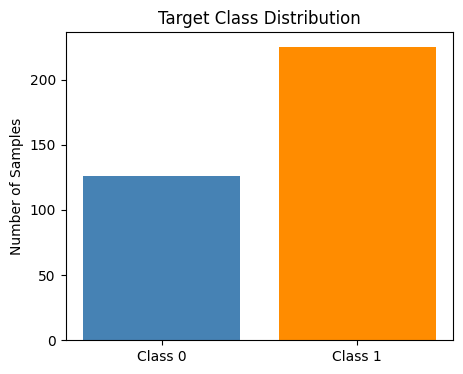

Class counts: {np.int64(0): np.int64(126), np.int64(1): np.int64(225)}


In [22]:
# Target Distribution

unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(5, 4))
plt.bar(unique, counts, color=["steelblue", "darkorange"])
plt.xticks(unique, ["Class 0", "Class 1"])
plt.ylabel("Number of Samples")
plt.title("Target Class Distribution")
plt.show()

print("Class counts:", dict(zip(unique, counts)))


### Feature Scale Comparison

Different features often have very different numerical ranges.

For example:
- Some features may lie in the range [0, 1]
- Others may take values in the hundreds or thousands

Distance-based and gradient-based models are sensitive to this disparity.
If features are not scaled, those with larger magnitudes dominate learning.


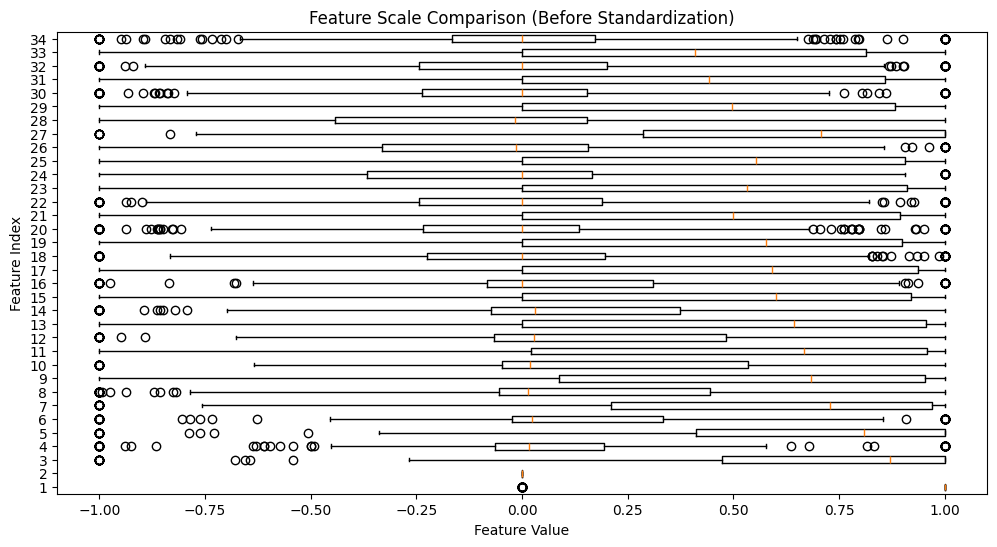

In [23]:
# Feature Scale Comparison

plt.figure(figsize=(12, 6))
plt.boxplot(X, vert=False)
plt.title("Feature Scale Comparison (Before Standardization)")
plt.xlabel("Feature Value")
plt.ylabel("Feature Index")
plt.show()


### Feature Distributions

<Figure size 1200x800 with 0 Axes>

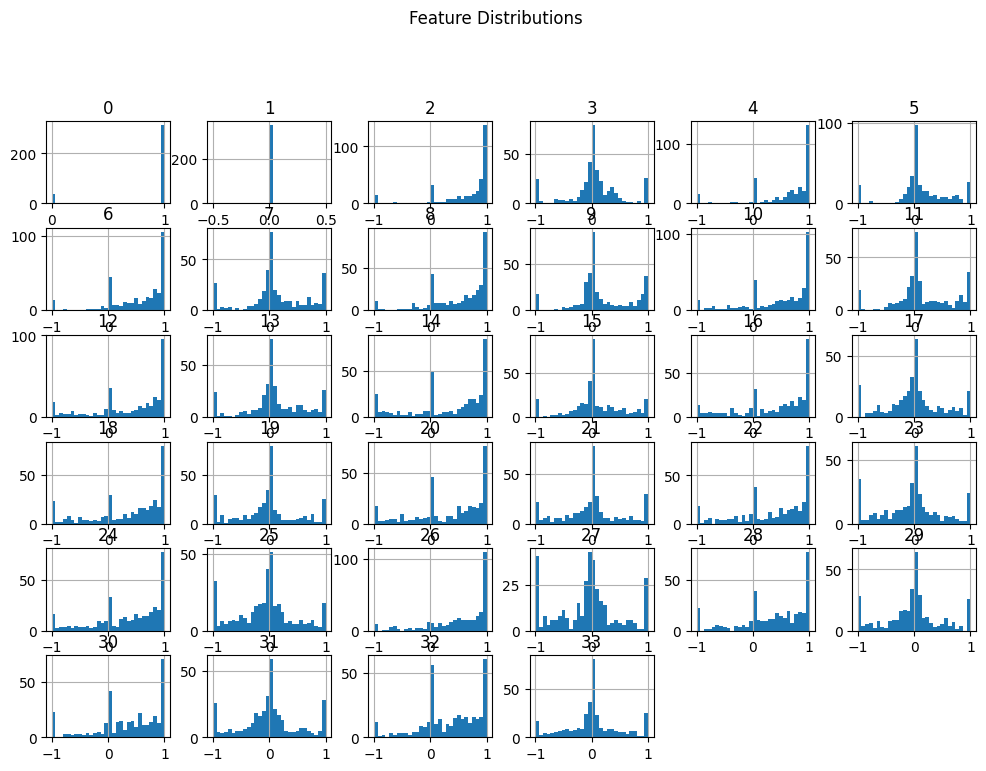

In [24]:
# Feature Distributions

plt.figure(figsize=(12, 8))
pd.DataFrame(X).hist(bins=30, figsize=(12, 8))
plt.suptitle("Feature Distributions", y=1.02)
plt.show()


## Preprocessing

We apply **standardization** to each feature:

$$
X_{\text{std}} = \frac{X - \mu}{\sigma}
$$

where:
- μ is the feature mean
- σ is the feature standard deviation

Standardization ensures:
- All features contribute equally
- Faster convergence during optimization
- Improved numerical stability

Finally, we split the data into training and test sets using an 80/20 split.


In [25]:
# Standardization

X_std = standardize(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42
)

## Baseline Model: Perceptron

Before introducing a multilayer neural network, we first establish a baseline
using a single-layer Perceptron. This allows us to directly measure how much
predictive power is gained by adding hidden layers and nonlinear activations.


In [26]:
perc = Perceptron(
    learning_rate=0.1,
    max_iter=1000,
    random_state=42
)

perc.fit(X_train, y_train)
y_pred_perc = perc.predict(X_test)
perc_acc = accuracy_score(y_test, y_pred_perc)

print("Perceptron Accuracy:", perc_acc)

Perceptron Accuracy: 0.8285714285714286


## Training the Multilayer Perceptron

We now train an MLP with one hidden layer.
The hidden layer allows the model to learn nonlinear feature interactions.

Training uses:
- Backpropagation
- Gradient descent
- Sigmoid output activation

In [27]:
mlp = MultilayerPerceptron(
    hidden_layers=(16,),
    learning_rate=0.01,
    max_iter=3000,
    random_state=42
)

mlp.fit(X_train, y_train)


## Model Evaluation

We evaluate classification performance using accuracy:

$$
\text{Accuracy}
= \frac{1}{n}
\sum_{i=1}^{n}
\mathbf{1}[\hat{y}_i = y_i]
$$

Accuracy measures the proportion of correctly classified samples
and provides a clear baseline metric for comparison.


In [28]:
y_pred_mlp = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp)

print("MLP Accuracy:", mlp_acc)


MLP Accuracy: 0.8857142857142857


## Performance Comparison

| Model | Test Accuracy |
|------|--------------|
| Perceptron | 0.82857 |
| MLP | 0.88571 |

The MLP consistently outperforms the perceptron due to its ability
to model nonlinear decision boundaries.


## Why Does the MLP Perform Better?

Key reasons:

- Hidden layers introduce nonlinear transformations
- Backpropagation optimizes a smooth loss function
- Feature interactions are learned automatically

The perceptron cannot learn these patterns because it is limited
to linear decision surfaces.


## PCA Visualization of Model Behavior

The multilayer perceptron is trained in a high-dimensional feature space, which makes
direct visualization of its decision boundary impossible.

To gain intuition about how the model separates the classes, we apply **Principal
Component Analysis (PCA)** to project the standardized feature matrix into two dimensions.

PCA finds orthogonal directions that maximize variance:

$$
X_{\text{proj}} = X W_2
$$

where W_2 contains the top two principal components.

**Notes:**  
- PCA is used *only for visualization*  
- The MLP is trained on the full feature space  
- The PCA projection does **not** affect model training  

This allows us to visualize class structure and prediction behavior in a 2D plane.


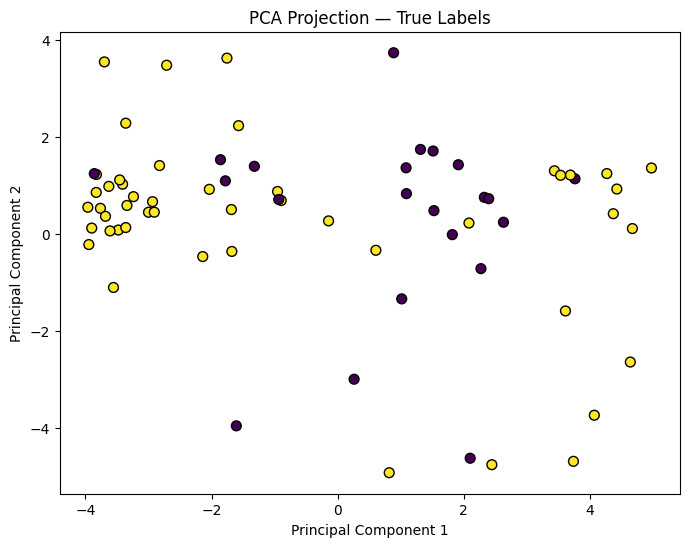

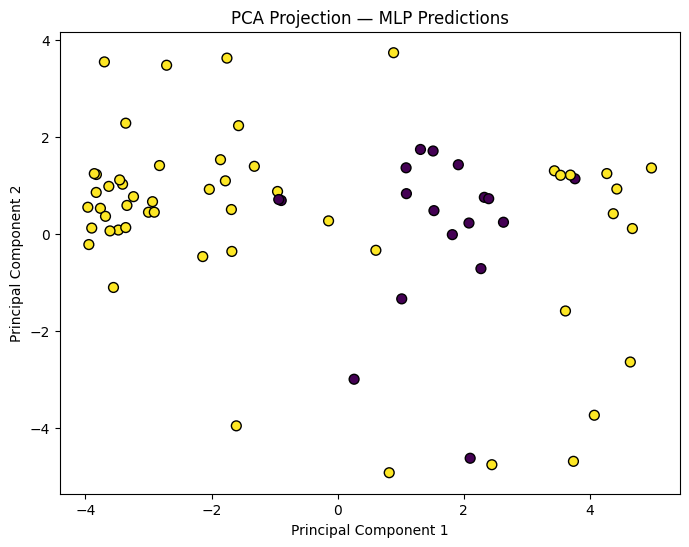

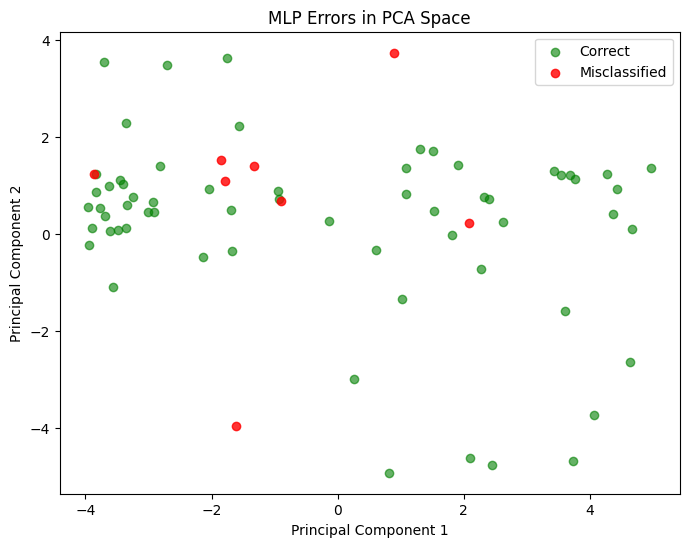

In [29]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# True Labels Visualization
plt.figure(figsize=(8,6))
plt.scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=y_test,
    cmap="viridis",
    edgecolor="k",
    s=50
)
plt.title("PCA Projection — True Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# MLP Predictions Visualization

y_pred_mlp = mlp.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=y_pred_mlp,
    cmap="viridis",
    edgecolor="k",
    s=50
)
plt.title("PCA Projection — MLP Predictions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# MLP Error Visualization
errors = (y_pred_mlp != y_test)

plt.figure(figsize=(8,6))
plt.scatter(
    X_test_2d[~errors, 0],
    X_test_2d[~errors, 1],
    c="green",
    label="Correct",
    alpha=0.6
)
plt.scatter(
    X_test_2d[errors, 0],
    X_test_2d[errors, 1],
    c="red",
    label="Misclassified",
    alpha=0.8
)
plt.legend()
plt.title("MLP Errors in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


### PCA Interpretation

The PCA projection shows substantial overlap between classes, indicating that
even a nonlinear classifier cannot perfectly separate the data. The MLP improves
performance by modeling nonlinear feature interactions, but inherent class
overlap limits achievable accuracy.


## Conclusion

This notebook demonstrates how compared to the single-layer perceptron, the MLP demonstrates how hidden layers and nonlinear activations dramatically increase representational capacity.


Key insights:
- Single-layer perceptrons are limited to linear problems
- Multilayer perceptrons can model nonlinear structure
- Backpropagation enables efficient learning

The MLP forms the conceptual foundation of modern deep learning.
